<a href="https://colab.research.google.com/github/DARoSLab/CS403-Intro-Robotics/blob/main/hws/hw2/hw2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Homework 2 Newton Method**
There are 3 questions in this homework. We have given you a starter code for all the questions. You only need to fillout the missing parts marked with "Fill in your code here".

# The Three Link Planar Manipulator 
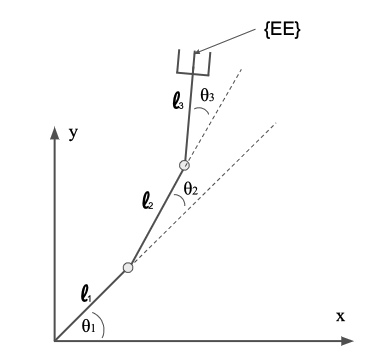

In [1]:
# python libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import animation
from IPython.display import HTML
from math import pi
%matplotlib inline

The following function can be used to plot the 3 DOF planar manipulator

In [2]:
def plot_planar_manipulator(q, l1=1, l2=1, l3=1, target=None, eff_path=None, interval=100):
  fig= plt.figure(figsize=(10,10))
  ax = plt.subplot(1,1,1)   

  link1, = ax.plot([], [], 'b', lw=10)     # ax.plot returns a list of 2D line objects
  link2, = ax.plot([], [], 'r', lw=10)
  link3, = ax.plot([], [], 'c', lw=10)

  eff, = ax.plot([], [], 'g', marker='o', markersize=15)
  if eff_path is not None:
    ep, = ax.plot(eff_path[:, 0], eff_path[:, 1], 'g-') 
  
  if target is not None:
    goal, = ax.plot([target[0]], [target[1]], 'r', marker='*', markersize=20)

  ax.set_xlim(( -3.5, 3.5))            
  ax.set_ylim((-3.5, 3.5))
  txt_title = ax.set_title('')
  def drawFrame(k):
    k = interval*k
    q0, q1, q2 = q[k]

    rA = [0, 0]
    rB = [l1*np.cos(q0), l2*np.sin(q0)]
    rC = [l1*np.cos(q0) + l2*np.cos(q0+q1), l1*np.sin(q0) + l2*np.sin(q0+q1)]
    rD = forward_kinematics(q[k, :], l1, l2, l3)[:2]

    link1.set_data([rA[0], rB[0]], [rA[1], rB[1]])
    link2.set_data([rB[0], rC[0]], [rB[1], rC[1]])
    link3.set_data([rC[0], rD[0]], [rC[1], rD[1]])
    eff.set_data([rD[0], rD[0]],[rD[1], rD[1]])
    return link1, link2, eff

  anim = animation.FuncAnimation(fig, drawFrame, frames=len(q)//interval, interval=100, blit=True)
  return anim

# Q.1 Derive the forward kinematics of the above three DoF planar manipulator. [5 points]

Use geometry to find the End Effector (EE) position in terms of joint coordinates ($q_1, q_2,$ and $q_3$ correspond to $\theta_1, \theta_2,$ and $\theta_3$ respectively). Note that this time we are including EE orientation in the variable named theta.

In [3]:
def forward_kinematics(q, l1=1, l2=1, l3=1):
  q0, q1, q2 = q
  x =  np.cos(q0)*l1 + l2*np.cos(q0+q1) + l3*np.cos(q0+q1+q2)
  y =  np.sin(q0)*l1 + l2*np.sin(q0+q1) + l3*np.sin(q0+q1+q2)
  theta = q0 + q1 + q2 # Fill your code here
  return np.array([x,y,theta])

Run the code below to see if your implementation is correct.

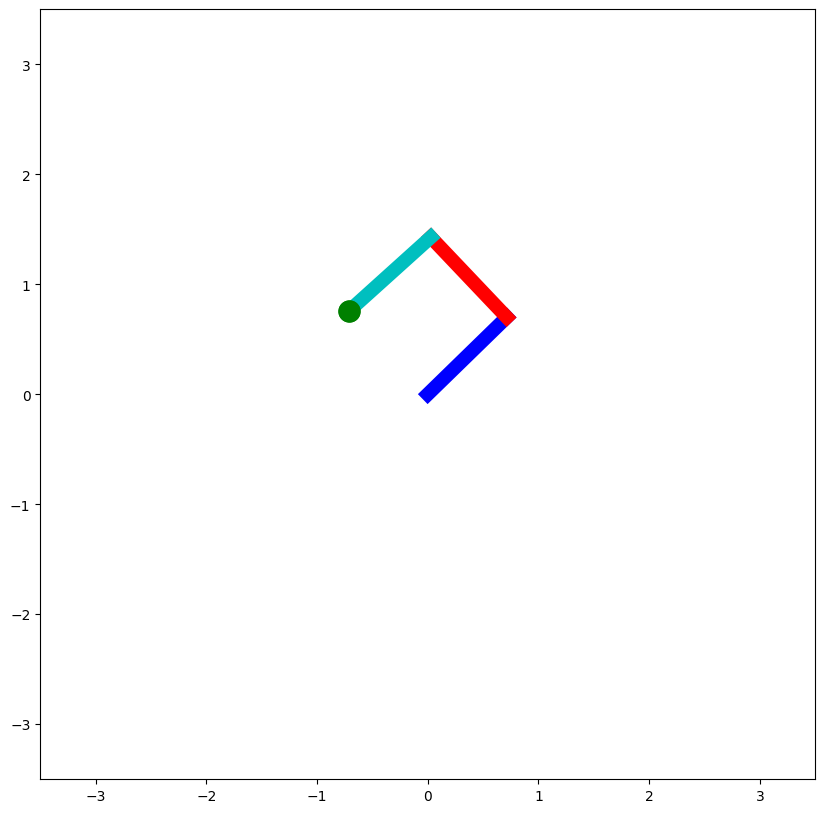

In [4]:

N = 8000
L1 = 1
L2 = 1
L3 = 1
q1 = np.linspace(0, np.pi/4, N)
q2 = np.linspace(0, np.pi/2, N)
q3 = np.linspace(0, np.pi/2, N)

q = np.zeros((N, 3))
q[:, 0] = q1
q[:, 1] = q2
q[:, 2] = q3

anim = plot_planar_manipulator(q, L1, L2, L3)
HTML(anim.to_html5_video())


Run the following test function to see if your FK implementation is correct.

In [5]:
def test_FK():
    tests = [
             [0.5, 0.7, 0.9],
             [0.9, 1.2, 0.3],
             [1.7, 0.3, 2.5]
            ]
    sols = [
            [0.73509421, 2.27467399, 2.1,],
            [-0.62062985, 2.32199946, 2.4],
            [-0.75578713, 0.92343212, 4.5]
           ]
    
    same = True
    for i in range(len(sols)):
      eval = forward_kinematics(tests[i])
      for j in range(3):
        if abs(eval[j] - sols[i][j]) > 0.01:
          same = False
    if same:
      print("Your FK implementation is correct!")
    else:
      print("Your FK implementation is NOT correct!")


    return
test_FK()

Your FK implementation is correct!


# Q2 Build Jacobian [10 points]

Calculate the Jacobian:

$$
\begin{pmatrix}
\dot{x} \\
\dot{y} \\
\dot{\theta} \\
\end{pmatrix} =
\begin{pmatrix}
\frac{d x}{d q_0} & 
\frac{d x}{d q_1} &
\frac{d x}{d q_2} \\
\frac{d y}{d q_0} & 
\frac{d y}{d q_1} &
\frac{d y}{d q_2} \\
\frac{d \theta}{d q_0} & 
\frac{d \theta}{d q_1} &
\frac{d \theta}{d q_2} \\ 
\end{pmatrix}
\begin{pmatrix}
\dot{q_0} \\
\dot{q_1} \\
\dot{q_2} \\
\end{pmatrix}
$$
> Find the partial derivatives and fill in the Jacobian matrix below (take partial derivatives of EE position w.r.t. joint position coordinates $q_0, q_1, q_2$ )

In [6]:
# Returns a function that can be used to get jacobian at the current state
def build_jacobian(l1=1, l2=1, l3=1):
    
    # 
    def evaluate_jacobian(q):
        # Use these variables and the link lengths in function def
        q0, q1, q2 = q

        J = [[], [], []]

        J[0] = [-l1*np.sin(q0) - l2*np.sin(q0+q1) - l3*np.sin(q0 + q1 + q2), -l2*np.sin(q0+q1) - l3*np.sin(q0 + q1 + q2), -l3*np.sin(q0 + q1 + q2)] # Your answers here
        J[1] = [l1*np.cos(q0) + l2*np.cos(q0+q1) + l3*np.cos(q0 + q1 + q2), l2*np.cos(q0+q1) + l3*np.cos(q0 + q1 + q2), l3*np.cos(q0 + q1 + q2)] # Your answers here
        J[2] = [1, 1, 1] # Your answers here

        return np.array(J)

    return evaluate_jacobian

# From now on we use the function below to evaluate jacobian at a given state
jacobian = build_jacobian()

Run the following function to test if your Jacobian is correct.

In [7]:
def test_jacobian():
    J = [[], [], []]
    J[0] = [-0.70317549, 0.13829549, 0.2794155] # Your answers here
    J[1] = [0.5104801, -0.02982221, 0.96017029] # Your answers here
    J[2] = [1, 1, 1] # Your answers here

    jacobian = build_jacobian(1, 1, 1)
    J_test = jacobian([1, 2, 3])

    same = True
    for i in range(3):
      for j in range(3):
          if abs(J[i][j] - J_test[i][j]) > 0.01:
            same = False

    print("Expected:")
    print(np.array(J))
    print("\nRecieved:")
    print(J_test)
    if same:
      print("\nYour Jacobian Implementation is correct!")
    else:
      print("\nYour Jacobian Implementation is NOT correct!")
    
    return
test_jacobian()

Expected:
[[-0.70317549  0.13829549  0.2794155 ]
 [ 0.5104801  -0.02982221  0.96017029]
 [ 1.          1.          1.        ]]

Recieved:
[[-0.70317549  0.13829549  0.2794155 ]
 [ 0.5104801  -0.02982221  0.96017029]
 [ 1.          1.          1.        ]]

Your Jacobian Implementation is correct!


#Q3 Newton-Raphson Method [20 points]


Implement the Newton-Raphson method. First compute the errror between the goal and EE position to get $d\bf x$, then use the psuedo-inverse of the Jacobian (done for you using numpy) to get the corresponding joint error $d\bf q$ and use that to update joint position accordingly. Repeat until $d \bf x$ is smaller than epsilon.

Your Newton-Raphson implementation is correct!


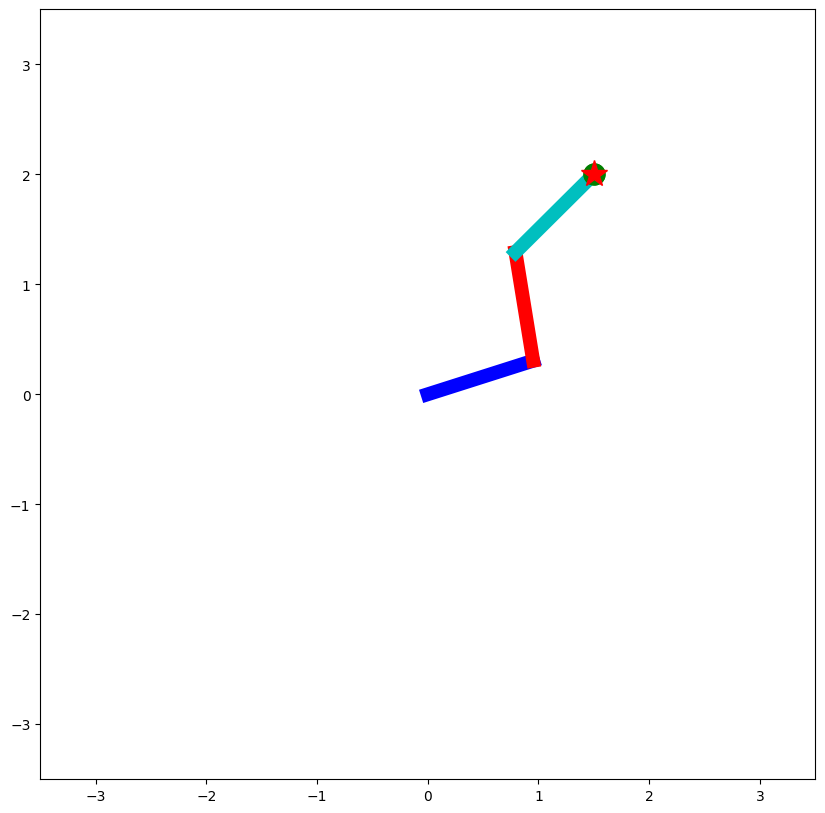

In [8]:
def newton_IK(x_goal, q_init):
  # array to hold joint position iterations
  q_anim = []

  # Choose an initial guess for joint position,
  qi = q_init

  q_anim += [qi.copy()]

  # Compute error between goal and current EE position
  d_x = x_goal - forward_kinematics(qi)

  # Small value at which we stop iterating if the error is smaller
  epsilon = 0.01
  step_size = 0.2
  iter = 0
  # Complete while loop
  while (iter<100): # Your code here
    # Your code here
    iter += 1
    if (d_x < epsilon).all():
      break
    else:
      qi = qi + np.dot(np.linalg.pinv(build_jacobian()(qi)).astype("float"), d_x)
      d_x = x_goal - forward_kinematics(qi)
      q_anim.append(qi)
  # Returns final joint position and joint data for animation
  return (qi, q_anim)



# A test to see if your implementation is correct
x_goal = np.array([1.5, 2, pi/4])
qi, q_anim = newton_IK(x_goal, np.array([0.5, 0.5, 0.5]))
sol = [0.31012806, 1.42090816, -0.94563806]
same = True
for i in range(3):
    if abs(sol[i] - qi[i]) > 0.02:
      same = False
if same:
    print("Your Newton-Raphson implementation is correct!")
else:
    print("Your Newton-Raphson implementation is NOT correct!")

anim = plot_planar_manipulator(np.array(q_anim), L1, L2, L3, target=x_goal, interval= 1)
HTML(anim.to_html5_video())

##Q3 IK Singular Posture [5 points]

Test your implementation with the following goal position, if there is a problem with getting IK for this posture try to explain why there is an issue. (Hint: is J always invertable?) Write your response in the text box below the code.

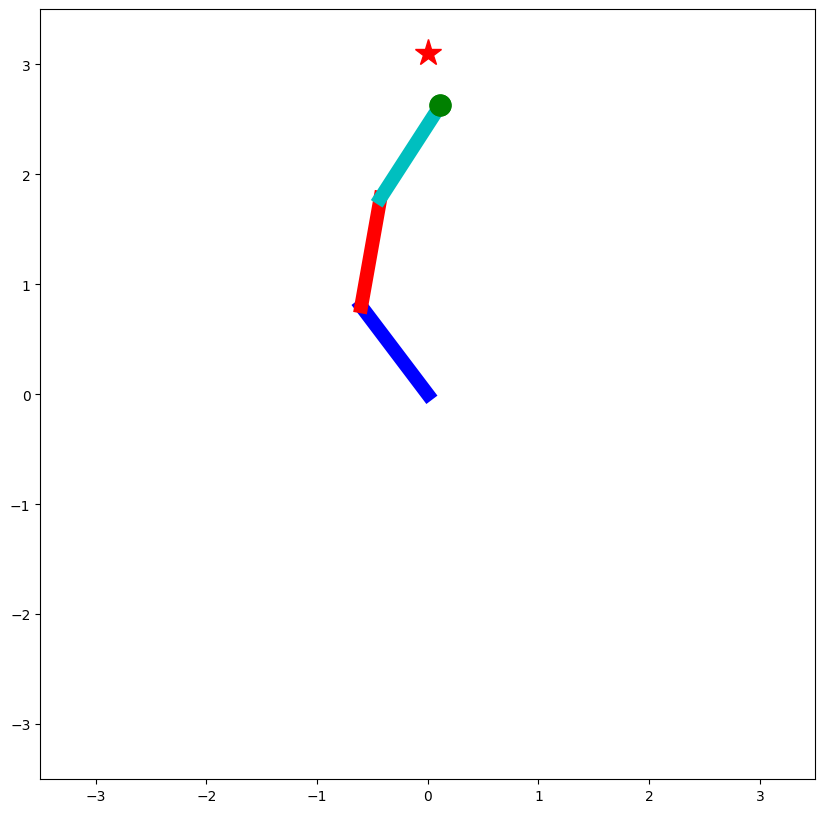

In [9]:
x_goal = np.array([0, 3.1, 1])
eval2, q_anim2 = newton_IK(x_goal, np.array([0.5, 0.5, 0.5]))
anim2 = plot_planar_manipulator(np.array(q_anim2), 1, 1, 1, target=x_goal, interval= 1)
HTML(anim2.to_html5_video())

Write your response here (Click edit on this text box):
The issue here is that it is impossible for the 3 combined arms of length 1 to reach the goal position. 1 + 1 + 1 < 3.1. For this reason the jacobian inverse technically does not exist but because we used the pseudo inverse, we end up getting values that jump near the goal position.